In [288]:
import rasterio
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.warp import transform
from tqdm import tqdm
from joblib import Parallel, delayed

In [289]:
def get_geotiff():
    with rasterio.open(FILE_NAME) as src:
        elev_data = src.read(1)
        
        # replace all 1e38 values with 0
        elev_data[elev_data >= 1e37] = 0
        return elev_data, src


In [299]:
def draw_dots_and_rays(ax, hits_list):
    print("Drawing on figure...")
    hits_arr = np.array(hits_list)
    xs, ys, ray_xs, ray_ys, elevs = hits_arr[:, 0], hits_arr[:, 1], hits_arr[:, 2], hits_arr[:, 3], hits_arr[:, 4]
    ax.scatter(xs, ys, s=DOT_RADIUS, c='red', marker='o')

    if DRAW_RAYS:
        ax.plot([xs, ray_xs], [ys, ray_ys], color='yellow', linewidth=1, alpha=LINE_ALPHA)

        
def plot_geotiff_with_visibility(locations):
    elev_data, _ = get_geotiff()
    
    print("Calculating viewing rays from locations...")
    hits = Parallel(n_jobs=-1)(delayed(shoot_ray_to_higher_altitude)(elev_data, x, y, angle) for x, y in tqdm(locations) for angle in range(MIN_ANGLE, MAX_ANGLE, ANGLE_STEP))

    if not DRAW_FIGURE:
        return
    
    # get the minimum and maximum values of the elevation data
    elev_min = np.nanmin(elev_data)
    elev_max = np.nanmax(elev_data)

    # create a Matplotlib figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 12))

    # plot the elevation data as an image
    im = ax.imshow(elev_data, cmap='terrain', vmin=elev_min, vmax=elev_max)

    # add a colorbar to the plot
    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Height in meters')
    
    # save the hits to a list
    hits_list = [hit for hit in hits if hit is not None]

    # draw dots and rays on ax afterwards (not in parallel)
    draw_dots_and_rays(ax, hits_list)

    # set the plot title and axis labels
    ax.set_title("Sunset visibility based on AHN3 elevation data")

    # save the plot
    if SAVE_PLOT:
        print("Saving plot...")
        plt.savefig(SAVED_PLOT_FILE_NAME, dpi=300)
        print("Saved plot!")
        
    
    # display the plot
    plt.show()


In [300]:
def shoot_ray_to_higher_altitude(elev_data, x, y, angle):
    # get the elevation at the location
    loc_elev = elev_data[y, x]

    # calculate the slope of the ray
    slope = np.tan(np.deg2rad(angle))

    # calculate the direction of the ray
    if angle > 90 and angle <= 270:
        x_dir = -1
    else:
        x_dir = 1

    if angle > 0 and angle <= 180:
        y_dir = -1
    else:
        y_dir = 1

    # start the ray at the location
    ray_x, ray_y = x, y

    # move the ray one pixel at a time until it hits a point at a higher altitude
    while True:
        # calculate the next pixel location along the ray
        next_x = ray_x + x_dir
        next_y = ray_y + y_dir * slope

        # check if the next pixel is out of bounds
        if next_x < 0 or next_x >= elev_data.shape[1] or next_y < 0 or next_y >= elev_data.shape[0]:
            break

        # check if the next pixel is at a higher altitude
        elev_diff = elev_data[int(next_y), next_x] - loc_elev
        if elev_diff > HEIGHT_THRESHOLD:
            break

        # update the ray position
        ray_x, ray_y = next_x, next_y
        
        # check if the ray exceeds the maximum distance
        distance = np.sqrt((ray_x - x) ** 2 + (ray_y - y) ** 2)
        if distance > MAX_RAY_DIST:
            break
        
    # check if the ray has reached far enough
    distance = np.sqrt((ray_x - x) ** 2 + (ray_y - y) ** 2)
    if distance < MIN_RAY_DIST:
        return None

    # if the ray hit a point at a higher altitude, consider this a valid hit
    if ray_x >= 0 and ray_x < elev_data.shape[1] and ray_y >= 0 and ray_y < elev_data.shape[0]:
        return (x, y, ray_x, ray_y, loc_elev)
    
    return None


In [301]:
def get_sample_grid_locations(n=10):
    elev_data, _ = get_geotiff()
    
    shape = elev_data.shape

    num_rows = n
    num_cols = n
    row_step = shape[0] // num_rows
    col_step = shape[1] // num_cols
    locations = []
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            row_start = row_idx * row_step
            col_start = col_idx * col_step
            x = col_start + col_step // 2
            y = row_start + row_step // 2
            locations.append((x, y))
    
    return locations

In [ ]:
MIN_ANGLE = 135
MAX_ANGLE = 225
ANGLE_STEP = 5
LINE_ALPHA = 0.02
HEIGHT_THRESHOLD = 0.25 # In meters. If ray hits a point higher than where its origin, still consider it visible if the difference is below this threshold
DRAW_FIGURE = True
DRAW_RAYS = True
DOT_RADIUS = 1
MIN_RAY_DIST = 750 # In meters, min viewing distance
MAX_RAY_DIST = 750 # In meters, max ray shooting distance
FILE_NAME = "R_31HN2.TIF"
SAVE_PLOT = True
SAVED_PLOT_FILE_NAME = "plot.png"

Calculating viewing rays from locations...


  8%|██▋                               | 21050/262144 [00:16<03:48, 1057.30it/s]

100%|█████████████████████████████████| 262144/262144 [02:00<00:00, 2168.34it/s]


Drawing on figure...
Saving plot...
Saved plot!


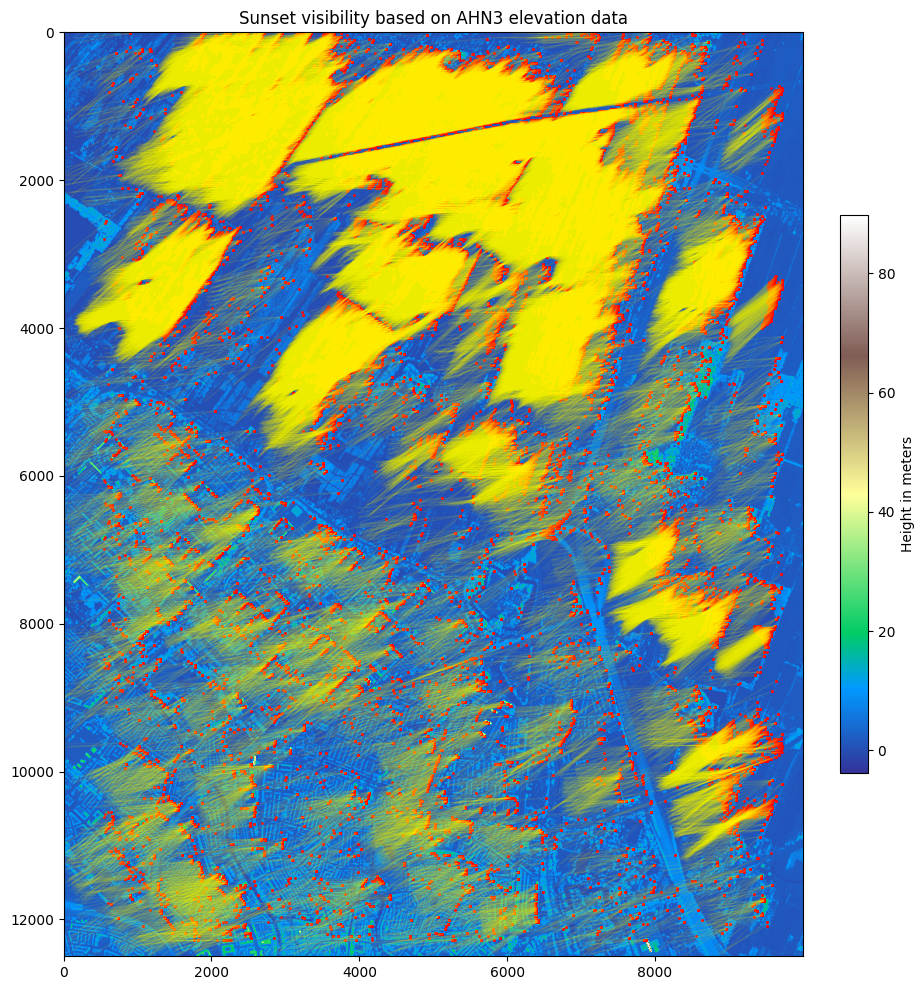

In [305]:
locations = get_sample_grid_locations(512)
plot_geotiff_with_visibility(locations)


